In [15]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import analytic_dLdp
from utils.regions import CircleExterior
from tracking_log import logger

style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting Utilities

In [9]:
def plot_trajectory(ax,traj,name,marker,size=50):
    def direction_at(i):
        direction = traj[i+1,:]-traj[i,:]
        return traj[i,0],traj[i,1], direction[0],direction[1]
    
    ax.scatter(traj[:,0],traj[:,1],label=name,marker=marker,s = size)
	


    
def plot_dist_to_source(ax,log):
    src_locs = log['src_locs']['source_1']
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(src_locs)])
        dist = np.linalg.norm(sensor_locs[:l]-src_locs[:l],axis = 1)
        ax.plot(dist,label = key)
    ax.set_title('Sensor-Source Distance vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
#     ax.legend()
    
def plot_L(ax,log):
    q = log['src_locs']['source_1']
    ps = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(q)])
        ps.append(sensor_locs[:l])
    ps = np.hstack(ps).reshape(-1,3,2)
    Ls = [f_L(q[i,:],ps[i,:]) for i in range(l)]
    ax.plot(np.log(Ls),label = r'$\log(L(p,q))$')
    
    for key,qhat in log['est_locs_log'].items():
        if key in["ekf"]:            
            Lhat = [f_L(qhat[i,:],ps[i,:]) for i in range(l)]
            ax.plot(np.log(Lhat),label = r'$\log(L(p,qhat))$')
      
    ax.legend(loc='lower right')
#     ax.set_title('log(L(ps,q)) vs Time steps',fontsize=15)
    ax.set_ylabel('log loss')

def plot_all(log,main_title,save_file_name):
    fig = plt.figure(dpi=100,figsize=(10,10))
    gs = fig.add_gridspec(2,1)

    
    ax = fig.add_subplot(gs[0,:])
    rectangle = plt.Rectangle((0,0), 3, 3, alpha=0.3,fc='red',ec="red")
    ax.add_artist(rectangle)
    ax.text(0.5,1.5,'Starting Region of the Sensors')
    plot_experiment(ax,log)
    
    ax = fig.add_subplot(gs[1,:])
    plot_dist_to_source(ax,log)
    
    
    ax.set_title(main_title,fontsize=20)
    
    fig.tight_layout()

    plt.savefig(save_file_name,bbox_inches='tight')


# animation function. This is called sequentially
def plot_experiment(ax,log):
#     ax.clear()

#     ax.set_xlim((0,7))
#     ax.set_ylim((0,7))

    ax.set_aspect('equal',adjustable='box')
           
    
    for key,val in log['src_locs'].items():
        plot_trajectory(ax,val,'Static Source','*',size = 400)

    for key,val in log['sensor_locs'].items():
        plot_trajectory(ax,val,"",'.',size=200)
    

    ax.legend(loc='right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    

In [3]:
def random_initial_poses(n_sensors,xmin,xmax,ymin,ymax):
    sensor_poses = np.zeros((n_sensors,2))
    sensor_poses[:,0]= xmin + np.random.rand(n_sensors)*(xmax-xmin)
    sensor_poses[:,1]= ymin + np.random.rand(n_sensors)*(ymax-ymin)
    return sensor_poses

## Main Loop

In [10]:
def main(n_sensors,std, N,fplan):
    
    # Set up mobile sensors and sources
    src_locs = [[6.,6]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    initial_locs = random_initial_poses(n_sensors,xmin=0,xmax=3,ymin=0,ymax=3)
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]

    CoM = np.mean(initial_locs,axis=0)

    ## Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    vs = virtual_sensor(C1,C0,b,k,std)
    
    # Set up location estimator
#     n_sensors = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sensors)
    C0s = C0*np.ones(n_sensors)
    ks = k * np.ones(n_sensors)
    bs = b*np.ones(n_sensors)
    initial_guess = np.array([4.,2.])
    xlim = (-np.inf,np.inf)
    ylim = (-np.inf,np.inf)

    estimator = getDynamicFilter(len(mobile_sensors),len(source),C1s,C0s,ks,bs,initial_guess,filterType="ekf",xlim=xlim,ylim=ylim)
    estimator_name = 'ekf'
    



    # Set up data logger
    log = logger(sensor_names,src_names)

    # Main Loop
   

    for _ in range(N):


        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)

        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        y = vs.measurement(qs,ps)
        
       # Estimate
        qhat = estimator.update_and_estimate_loc(ps,y)
        
        # Plan
        waypoints = fplan(qhat,ps)
        # Move
        for i in range(n_sensors):
            mobile_sensors[i].update_loc(waypoints[0][i])

    return log


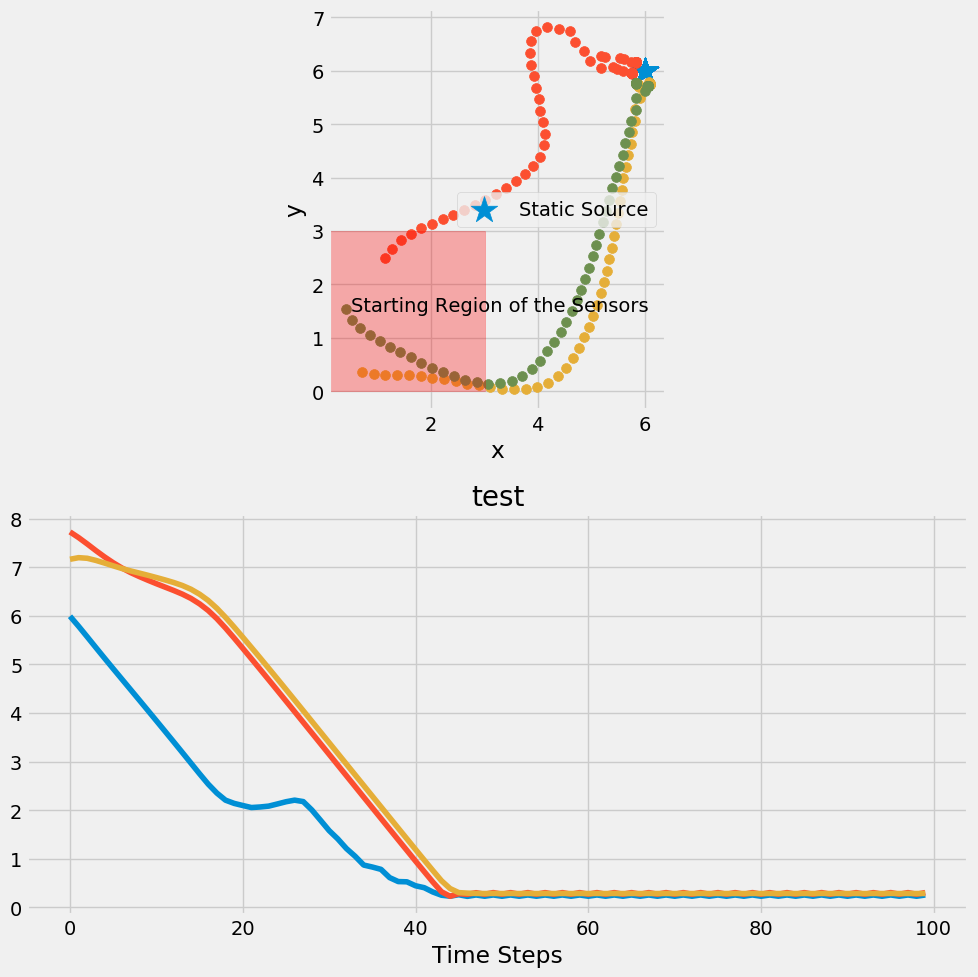

In [11]:

# Set up waypoint planner
n_sensors=3
C0=0
C1 = -0.5
k=1
b=-2
C1s=C1*np.ones(n_sensors)
C0s = C0*np.ones(n_sensors)
ks = k * np.ones(n_sensors)
bs = b*np.ones(n_sensors)

f_dLdp=dLdp(C1s=C1s,C0s=C0s,ks=ks,bs=bs)
planning_timesteps = 1
max_linear_speed = 0.22
planning_dt = 1
epsilon = 0.1
# The FIM waypoint planning  
fplan = lambda qs,ps:FIM_ascent_path_planning(f_dLdp,qs,ps,n_sensors,\
                planning_timesteps,\
                max_linear_speed,\
                planning_dt,\
                epsilon,\
                # Rect2D(self.xlim,self.ylim))
                CircleExterior(np.array([6,6]),0))

log = main(n_sensors,0.01,100,fplan)
plot_all(log.export(),'test','test.png')

## Run experiments and save data

In [12]:
def get_dists_to_src(log):
    src_locs = log['src_locs']['source_1']
    dists = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(src_locs)])
        dists.append(np.linalg.norm(sensor_locs[:l]-src_locs[:l],axis = 1))
    return np.array(dists)

In [13]:
# Experiment parameters
noise_std = 0.01
N_steps = 100
N_expr = 100
N_sensors = [3,10,20,50]


In [18]:
# Data container
experiment = {n:[] for n in N_sensors}

for n_sensors in N_sensors:
    print(n_sensors)
    dists = []
    
    # Set up fplan
    C1=0
    C0=-0.5
    k=1
    b=-2
    C1s=C1*np.ones(n_sensors)
    C0s = C0*np.ones(n_sensors)
    ks = k * np.ones(n_sensors)
    bs = b*np.ones(n_sensors)

    f_dLdp=partial(analytic_dLdp,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    planning_timesteps = 1
    max_linear_speed = 0.22
    planning_dt = 1
    epsilon = 0.1
    # The FIM waypoint planning  
    fplan = lambda qs,ps:FIM_ascent_path_planning(f_dLdp,qs,ps,n_sensors,\
                    planning_timesteps,\
                    max_linear_speed,\
                    planning_dt,\
                    epsilon,\
                    # Rect2D(self.xlim,self.ylim))
                    CircleExterior(np.array([6,6]),0))
    
    for _ in range(N_expr):
        print("{} in {} experiments finished".format(_,N_expr))
        log=main(n_sensors,noise_std,N_steps,fplan)
        dists.append(get_dists_to_src(log.export()))
    data = {'format':'dists[num_experiments,n_sensor,N_steps]','data':np.array(dists)}
    experiment[n_sensors]=data

3
0 in 100 experiments finished
1 in 100 experiments finished
2 in 100 experiments finished
3 in 100 experiments finished
4 in 100 experiments finished
5 in 100 experiments finished
6 in 100 experiments finished
7 in 100 experiments finished
8 in 100 experiments finished
9 in 100 experiments finished
10 in 100 experiments finished
11 in 100 experiments finished
12 in 100 experiments finished
13 in 100 experiments finished
14 in 100 experiments finished
15 in 100 experiments finished
16 in 100 experiments finished
17 in 100 experiments finished
18 in 100 experiments finished
19 in 100 experiments finished
20 in 100 experiments finished
21 in 100 experiments finished
22 in 100 experiments finished
23 in 100 experiments finished
24 in 100 experiments finished
25 in 100 experiments finished
26 in 100 experiments finished
27 in 100 experiments finished
28 in 100 experiments finished
29 in 100 experiments finished
30 in 100 experiments finished
31 in 100 experiments finished
32 in 100 experi

KeyboardInterrupt: 

In [39]:
filename = 'FIMDists.pkl'
pkl.dump(experiment,open(filename,'wb'))

In [6]:
filename = 'FIMDists.pkl'
experiment = pkl.load(open(filename,'rb'))

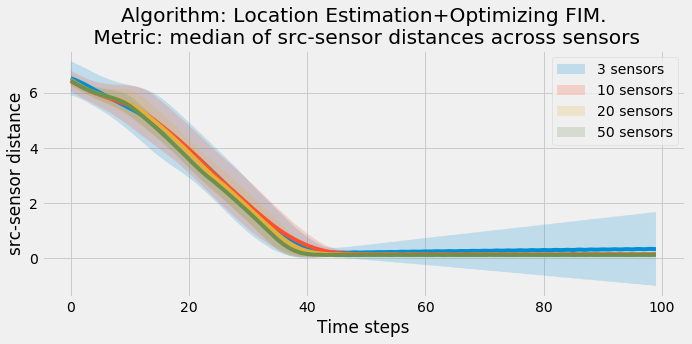

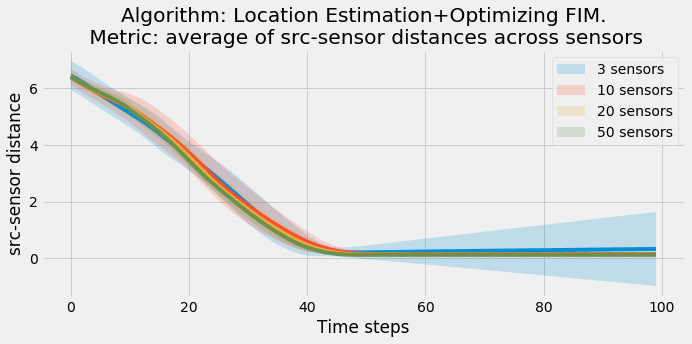

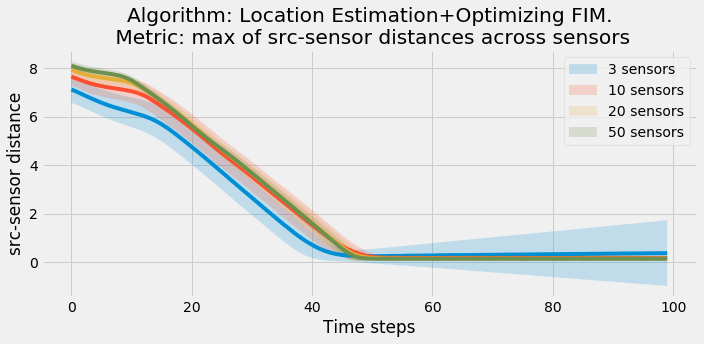

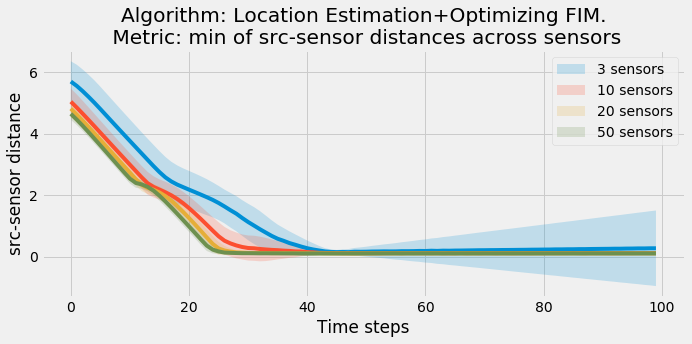

In [8]:
metrics = {'median':np.median,'average':np.mean,'max':np.max,'min':np.min}
for metric_name,metric_method in metrics.items():
    plt.figure(figsize=(10,5))
    for n_sensor in N_sensors:
        metric = metric_method(experiment[n_sensor]['data'],axis=1)
        dist = np.mean(metric,axis=0)
        sd = np.std(metric,axis = 0)
        x=range(len(dist))
        plt.plot(x,dist)
        plt.fill_between(x,dist-sd,dist+sd,alpha=0.2,label = '{} sensors'.format(n_sensor))
    plt.xlabel('Time steps')
    plt.ylabel('src-sensor distance')
    plt.title("Algorithm: Location Estimation+Optimizing FIM.\n Metric: {} of src-sensor distances across sensors".format(metric_name))
    plt.legend()
    plt.tight_layout()
    plt.savefig("FIM{}.png".format(metric_name))
    plt.show()